In [1]:
import geopandas
import pandas as pd
import numpy as np
import random
import math
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
import folium
import geopandas
from shapely.geometry import Point

In [2]:
def draw_population(df, weights):
    df2 = df.loc[np.repeat(df.index.values, weights)]
    return df2

# Data

In [3]:
buildings = geopandas.read_file('data/by_get.shp')
buildings = buildings.to_crs("EPSG:4326")
buildings.geometry = buildings.geometry.centroid

/tmp/ipykernel_19944/3322037153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings.geometry = buildings.geometry.centroid


In [4]:
ruta1000 = geopandas.read_file('data/B1 ruta 1000 difference with 250.shp')
ruta1000 = ruta1000.to_crs("EPSG:4326")

ruta250 = geopandas.read_file('data/B1 ruta 250.shp')
ruta250 = ruta250.to_crs("EPSG:4326")

rutas = geopandas.GeoDataFrame(pd.concat([ruta250, ruta1000], axis=0))

rutas['Ruta'] = rutas.Ruta.astype(int)
rutas = rutas.set_index('Ruta')

In [5]:
houses = buildings[buildings.ANDAMAL_1 < 200]
workplaces = geopandas.read_file('data/workplaces_OSM_SCB_merged.geojson')

In [6]:
resfil_raw = pd.read_csv('data/RVU_resfil.csv')
individfil = pd.read_csv('data/RVU_individfil.csv')

resfil_raw = resfil_raw[resfil_raw['dagtyp'] == 1]
individfil = individfil[individfil['dagtyp'] == 1]

In [7]:
resfil_raw['rf3a_ärende'] = resfil_raw.rf3a_ärende.replace(88.0, 14.0)
resfil_raw['rf3a_ärende'] = resfil_raw.rf3a_ärende.fillna(14.0)
resfil_raw['rf3a_ärende'] = resfil_raw['rf3a_ärende'].astype(int)

# Change age grouping

In [8]:
bins = [6, 15, 19, 24, 44, 64, 999]
age_groups = ['Ald7_15','Ald16_19','Ald20_24','Ald25_44','Ald45_64','Ald65_W'] # 'Ald0_6' are excluded
resfil_raw['age_scb'] = pd.cut(resfil_raw.alder_tab, bins=bins, labels=age_groups)
individfil['age_scb'] = pd.cut(individfil.alder_tab, bins=bins, labels=age_groups)

# Find P(trip_chain|age)

In [9]:
# freq_age = []
# for age in age_groups:
#     trip_chains = {}  
    
#     # no trips in a day for age bin
#     trip_chains[()] = individfil[(individfil['resa.antal'] == 0) & (individfil['age_scb'] == age)].individvikt.sum()
        
#     for pid in resfil_raw[resfil_raw.age_scb == age].Id.unique():    
#         trips = resfil_raw[resfil_raw.Id == pid]
#         chain = tuple(trips['rf3a_ärende'].to_list())
        
#         if any([math.isnan(x) for x in chain]):
#             chain = tuple(14.0 if math.isnan(x) else x for x in chain)
#         chain = tuple(14 if x==88 else x for x in chain)
        
#         if chain in trip_chains.keys():
#             trip_chains[chain] += trips['individvikt'].iloc[0]
#         else:
#             trip_chains[chain] = trips['individvikt'].iloc[0]
#     freq_age.append(pd.DataFrame.from_dict(trip_chains, orient='index',columns=[age]))
    
# freq_age = freq_age[0].join(freq_age[1], how='outer').join(freq_age[2], how='outer').join(freq_age[3], how='outer').join(freq_age[4], how='outer').join(freq_age[5], how='outer').fillna(0)


In [10]:
# freq_age

In [11]:
# freq_age = freq_age/freq_age.sum()

In [12]:
# freq_age

# distances between rutas

In [13]:
rutas_distance = pd.read_feather("data/rutas_distance_matrix.feather")

In [14]:
rutas_distance.columns = rutas_distance.columns.astype(int)
rutas_distance.index = rutas_distance.columns

In [15]:
rutas_distance.head()

,3495006225750250,3490006226500250,3490006226750250,3495006224750250,3500006224250250,3487506225000250,3487506226000250,3482506228000250,3500006223750250,3487506224750250,...,43100061620001000,43300062410001000,43200061590001000,43100062370001000,43100062420001000,43100061690001000,43100061960001000,43200061440001000,43200061890001000,43100062440001000
3495006225750250,0.0,2047.0,2115.1,1738.3,2356.8,1436.8,1439.2,3872.9,2950.8,1561.8,...,126910.0,109067.6,129212.5,109409.7,111759.0,127454.5,130944.9,142525.3,128878.1,115988.4
3490006226500250,2079.5,0.0,982.8,2326.4,2944.8,2024.8,789.7,2579.7,3538.8,2149.8,...,127498.0,109655.6,129800.5,109997.7,112347.0,128042.5,131532.9,143113.3,129466.1,116576.4
3490006226750250,2147.6,982.8,0.0,2394.4,3012.9,2092.9,857.8,1961.8,3606.9,2217.9,...,127566.1,109723.6,129868.5,110065.8,112415.0,128110.6,131601.0,143181.3,129534.1,116644.5
3495006224750250,1710.2,2326.9,2395.0,0.0,895.9,837.4,1719.1,5605.9,1489.9,907.4,...,125449.1,107606.7,127751.6,107948.8,110298.1,125993.6,129484.0,141064.4,127417.1,114527.5
3500006224250250,2328.7,2945.4,3013.5,895.9,0.0,1811.4,2337.5,6028.4,695.6,1765.9,...,124654.8,106812.3,126957.2,107154.5,109503.7,125199.3,128689.7,140270.0,126622.8,113733.2


In [16]:
rutas_with_buildings = pd.read_feather('data/rutas_with_buildings.feather')

In [17]:
rutas_with_buildings['index'] = (rutas_with_buildings.reset_index().Ruta.astype(str).values + rutas_with_buildings.Rutstorl.astype(str).values).astype(int)
rutas_with_buildings = rutas_with_buildings.reset_index().set_index('index')

In [18]:
rutas_with_buildings.head()

,Ruta,Rutstorl,Ald0_6,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W,Totalt,houses_in_ruta,workplaces_in_ruta
index,,,,,,,,,,,,
3495006225750250,3495006225750,250,4,14,7,0,13,19,9,66,"[44906, 45233, 45715, 45863, 46007, 48302, 491...","[2924, 14843, 23952, 23953, 23954, 24409]"
3490006226500250,3490006226500,250,13,29,16,4,29,50,33,174,"[44713, 44770, 44850, 44903, 44913, 44956, 450...",[3810]
3490006226750250,3490006226750,250,0,0,0,0,5,5,10,20,"[45385, 45761, 46160, 47033, 47443, 47722, 477...",[]
3495006224750250,3495006224750,250,3,10,7,3,11,36,30,100,"[262, 44609, 44711, 44918, 45305, 45312, 45530...","[2894, 2919, 30780]"
3500006224250250,3500006224250,250,0,3,0,0,4,3,5,15,"[46345, 47484, 47589, 48152, 49000, 239923]","[14844, 28533]"


In [19]:
rutas['index'] = (rutas.reset_index().Ruta.astype(str).values + rutas.Rutstorl.astype(str).values).astype(int)
rutas = rutas.reset_index().set_index('index')

In [20]:
rutas.head()

,Ruta,Rutstorl,Ald0_6,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W,Totalt,geometry
index,,,,,,,,,,,
3495006225750250,3495006225750,250,4,14,7,0,13,19,9,66,"POLYGON ((12.57704 56.15298, 12.57690 56.15523..."
3490006226500250,3490006226500,250,13,29,16,4,29,50,33,174,"POLYGON ((12.56858 56.15956, 12.56843 56.16180..."
3490006226750250,3490006226750,250,0,0,0,0,5,5,10,20,"POLYGON ((12.56843 56.16180, 12.56829 56.16405..."
3495006224750250,3495006224750,250,3,10,7,3,11,36,30,100,"POLYGON ((12.57761 56.14401, 12.57747 56.14625..."
3500006224250250,3500006224250,250,0,3,0,0,4,3,5,15,"POLYGON ((12.58593 56.13968, 12.58579 56.14192..."


In [21]:
building_columns = ['houses_in_ruta', 'workplaces_in_ruta']

In [22]:
rutas[building_columns] = rutas_with_buildings[building_columns]

In [23]:
rutas.head()

,Ruta,Rutstorl,Ald0_6,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W,Totalt,geometry,houses_in_ruta,workplaces_in_ruta
index,,,,,,,,,,,,,
3495006225750250,3495006225750,250,4,14,7,0,13,19,9,66,"POLYGON ((12.57704 56.15298, 12.57690 56.15523...","[44906, 45233, 45715, 45863, 46007, 48302, 491...","[2924, 14843, 23952, 23953, 23954, 24409]"
3490006226500250,3490006226500,250,13,29,16,4,29,50,33,174,"POLYGON ((12.56858 56.15956, 12.56843 56.16180...","[44713, 44770, 44850, 44903, 44913, 44956, 450...",[3810]
3490006226750250,3490006226750,250,0,0,0,0,5,5,10,20,"POLYGON ((12.56843 56.16180, 12.56829 56.16405...","[45385, 45761, 46160, 47033, 47443, 47722, 477...",[]
3495006224750250,3495006224750,250,3,10,7,3,11,36,30,100,"POLYGON ((12.57761 56.14401, 12.57747 56.14625...","[262, 44609, 44711, 44918, 45305, 45312, 45530...","[2894, 2919, 30780]"
3500006224250250,3500006224250,250,0,3,0,0,4,3,5,15,"POLYGON ((12.58593 56.13968, 12.58579 56.14192...","[46345, 47484, 47589, 48152, 49000, 239923]","[14844, 28533]"


# Sampling (home location|ruta) (trip chain|age)

In [24]:
columns = rutas.columns

In [25]:
# persid = 0
# persons_df = None
# skipped_rutas = []
# for _,ruta in rutas.sample(1).iterrows():   
#     ruta = rutas.loc[3937506190000250]
# #     ruta_repeated = geopandas.GeoDataFrame(np.repeat([ruta.values], len(houses.index), axis=0), columns=columns, geometry='geometry', crs="EPSG:4326")
# #     ruta_buildings = houses[ruta_repeated.contains(houses.geometry)]
    
#     ruta_buildings = houses.loc[ruta.houses_in_ruta]    
    
#     ages = np.repeat(ruta[age_groups].index, ruta[age_groups].values)
#     ids = range(persid, persid + ruta.Totalt - ruta.Ald0_6)
#     persid += ruta.Totalt
# #     name is the 
#     ruta_df = np.array([ruta.Ruta]).repeat(len(ids))
#     rutstorl_df = np.array([ruta.Rutstorl]).repeat(len(ids))
    
#     # to make DF with person ID and ages
#     persons = pd.DataFrame({'id': ids,
#                             'age': ages,
#                            'Ruta': ruta_df,
#                            'Rutstorl': rutstorl_df}
#     )
    
#     #sample home location
#     if len(ruta_buildings.index) == 0:
#         # if ruta has no buildings, it can be outside skåne
#         skipped_rutas.append(str(ruta.Ruta))
#         continue
#         #         if ruta has no buildings, take its centroid
# #         persons['home'] = [ruta.geometry.centroid]*len(persons.index)
#     else:
#         persons['home'] = ruta_buildings.sample(n=len(persons.index), replace=True).geometry.values
    
#     #sample trip chain | age
#     chains = []
#     for n,age in zip(ruta[age_groups], age_groups):
#         chains.append(freq_age[age].sample(n=n, weights=freq_age[age].values, replace=True))
#     persons["trip_chain"] = pd.concat(chains).index
    
#     # save to dict
#     if persons_df is None:
#         persons_df = persons
#     else:
#         persons_df = pd.concat([persons_df,persons], axis=0, ignore_index=True)       
        
#     break
# print(skipped_rutas)

In [26]:
# persons_df

# Trip chain to trip pairs

In [27]:
# persons_df['chain_length'] = persons_df.trip_chain.apply(len)

In [28]:
# persons_df_repeated = persons_df.loc[np.repeat(persons_df.index.values, persons_df.chain_length)]

In [29]:
# persons_df_repeated

In [30]:
# trip_pairs = []
# for row in persons_df.itertuples():
#     chain = row.trip_chain
#     for f,s in zip([1.0] + [i for i in chain], chain):
#         trip_pairs.append((f,s))

In [31]:
# len(trip_pairs)

In [32]:
# persons_df_repeated['trip_pair'] = trip_pairs

In [33]:
# persons_df_repeated

# prepare trip length distributions

In [34]:
upsampled_resfil = draw_population(resfil_raw[['rf7_km', 'age_scb', 'rf3a_ärende']], resfil_raw.individvikt)
upsampled_resfil = upsampled_resfil.dropna(subset=['rf7_km'])

In [35]:
distance = np.linspace(1, 500, 500)

In [36]:
# fig, ax = plt.subplots(nrows=6, ncols=17, figsize=(300,70))

# prob_age_type = {}

# for age,axj in zip(age_groups, range(0,7)):
#     loc_resfil = upsampled_resfil[upsampled_resfil['age_scb'] == age]
    
# #     fig, ax = plt.subplots(nrows=18, figsize=(7,30))
    
#     axi = loc_resfil.rf3a_ärende.unique().astype(int) - 1
#     axi.sort()
#     loc_resfil.hist(column=['rf7_km'], by=['rf3a_ärende'],bins=range(0,100, 1), density=True, ax=ax[axj][axi])

#     for axm, ind in zip(ax[axj].flat, range(1,18)):
#         df = loc_resfil[loc_resfil['rf3a_ärende']==ind]
#         if len(df.index) == 0:
#             continue
        
#         kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
#         log_dens = kde.score_samples(distance[:, np.newaxis])
#         probability = np.exp(log_dens)
        
#         prob_age_type[(age, ind)] = probability
        
#         axm.plot(distance, probability)
# fig.savefig('data/age-type-legth-hist.pdf')

In [37]:
# prob_age_type = pd.DataFrame(prob_age_type)
# prob_age_type.index = distance.astype(int)
# prob_age_type.head()

In [38]:
# prob_age_type = prob_age_type.reset_index(drop=True)
# prob_age_type.columns = pd.MultiIndex.from_tuples(prob_age_type.columns.to_series().apply(lambda x: (str(x[0]), str(x[1]))).values)
# prob_age_type.to_parquet('data/prob_age_type.parquet')

In [39]:
prob_age_type = pd.read_parquet('data/prob_age_type.parquet')
prob_age_type.columns = pd.MultiIndex.from_tuples(prob_age_type.columns.to_series().apply(lambda x: (str(x[0]), int(x[1]))).values)
prob_age_type.index = distance.astype(int)
prob_age_type.head()

Ald7_15                                                                  \
         1             2         4         6         7         8         10   
1  0.057626  7.922598e-07  0.060643  0.065802  0.061466  0.015790  0.046065   
2  0.059860  2.028170e-06  0.062509  0.070782  0.062448  0.022184  0.050349   
3  0.060123  4.988494e-06  0.062331  0.073608  0.061113  0.029945  0.053461   
4  0.058444  1.178861e-05  0.060201  0.073980  0.057619  0.038837  0.055192   
5  0.055048  2.676605e-05  0.056409  0.071837  0.052348  0.048394  0.055454   

                                 ...   Ald65_W                                \
         11        12        13  ...        8         9         10        11   
1  0.043143  0.069877  0.065361  ...  0.043599  0.049922  0.055881  0.053960   
2  0.045386  0.074207  0.067125  ...  0.045901  0.052335  0.058751  0.056082   
3  0.046300  0.076020  0.066512  ...  0.046905  0.053256  0.059764  0.056452   
4  0.045896  0.075104  0.063613  ...  0.046611  0.052704  0.058885  0.055105   
5  0.044319  0.071535  0.058754  ...  0.045143  0.050838  0.056271  0.052244   

                                                               
         12        13        14        15        16        17  
1  0.043001  0.035785  0.048275  0.053860  0.048583  0.006645  
2  0.045234  0.038530  0.050093  0.057450  0.051026  0.007700  
3  0.046146  0.040341  0.050434  0.059517  0.051982  0.008862  
4  0.045727  0.041150  0.049356  0.059973  0.051450  0.010126  
5  0.044098  0.040986  0.047050  0.058872  0.049576  0.011475  

[5 rows x 95 columns]

In [40]:
# prob_type = {}
# fig, ax = plt.subplots(nrows=17, figsize=(7,30))
# upsampled_resfil.hist(column=['rf7_km'], by=['rf3a_ärende'],bins=range(0,100, 1), density=True, ax=ax)

# for axi, ind in zip(ax.flat, range(1,18)):
#     df = upsampled_resfil[['rf7_km', 'rf3a_ärende']][upsampled_resfil['rf3a_ärende']==ind]
#     kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
#     log_dens = kde.score_samples(distance[:, np.newaxis])
#     probability = np.exp(log_dens)

#     prob_type[ind] = probability

#     axi.plot(distance, probability)
# fig.savefig('data/type-legth-hist.pdf')

In [41]:
# prob_type = pd.DataFrame(prob_type)
# prob_type.index = distance.astype(int)
# prob_type

In [42]:
# prob_type = prob_type.reset_index(drop=True)
# prob_type.columns = prob_type.columns.astype(str)
# prob_type.to_parquet('data/prob_type.parquet')

prob_type = pd.read_parquet('data/prob_type.parquet')
prob_type.columns = prob_type.columns.astype(int)
prob_type.index = distance.astype(int)
prob_type.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,0.042844,0.033243,0.031519,0.040862,0.055631,0.059918,0.048328,0.043851,0.049918,0.056110,0.051037,0.048930,0.039697,0.046657,0.049550,0.042562,0.016678
2,0.045198,0.035684,0.033730,0.042783,0.057358,0.061665,0.051039,0.046181,0.052307,0.058947,0.053445,0.050689,0.042116,0.048694,0.052926,0.045500,0.017222
3,0.046262,0.037216,0.035015,0.043423,0.057261,0.061428,0.052321,0.047182,0.053181,0.059965,0.054221,0.050872,0.043357,0.049288,0.054944,0.047234,0.017398
4,0.046016,0.037777,0.035317,0.042794,0.055425,0.059310,0.052143,0.046851,0.052552,0.059138,0.053366,0.049541,0.043382,0.048468,0.055529,0.047691,0.017257
5,0.044567,0.037399,0.034681,0.041039,0.052104,0.055596,0.050610,0.045314,0.050573,0.056623,0.051040,0.046903,0.042275,0.046401,0.054733,0.046925,0.016869


In [43]:
# prob_age = {}
# fig, ax = plt.subplots(nrows=6, figsize=(7,15))
# upsampled_resfil.hist(column=['rf7_km'], by=['age_scb'],bins=range(0,100, 1), density=True, ax=ax)

# for axi, age in zip(ax.flat, age_groups):
#     df = upsampled_resfil[['rf7_km', 'age_scb']][upsampled_resfil['age_scb']==age]
#     kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(df['rf7_km'][:, np.newaxis])
#     log_dens = kde.score_samples(distance[:, np.newaxis])
#     probability = np.exp(log_dens)

#     prob_age[age] = probability

#     axi.plot(distance, probability)
# fig.savefig('data/age-legth-hist.pdf')

In [44]:
# prob_age = pd.DataFrame(prob_age)
# prob_age.index = distance.astype(int)
# prob_age

In [45]:
# prob_age.to_parquet('data/prob_age.parquet')

In [46]:
prob_age = pd.read_parquet('data/prob_age.parquet')
prob_age.head()

,Ald7_15,Ald16_19,Ald20_24,Ald25_44,Ald45_64,Ald65_W
1,0.058003,0.038390,0.045205,0.042937,0.040168,0.049341
2,0.060229,0.040647,0.047094,0.045006,0.042752,0.051779
3,0.060505,0.041773,0.047503,0.045754,0.044180,0.052687
4,0.058869,0.041750,0.046455,0.045184,0.044404,0.052064
5,0.055550,0.040670,0.044120,0.043433,0.043490,0.050059


array([[<AxesSubplot:title={'center':'rf7_km'}>]], dtype=object)

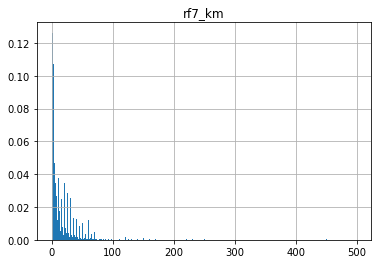

In [47]:
upsampled_resfil.hist(column=['rf7_km'], bins=range(0,500, 1), density=True)

# Add buildings of other types

In [48]:
rutas_other_buildings = pd.read_feather('data/rutas_with_other_buildings.feather')

In [49]:
rutas_other_buildings = rutas_other_buildings.reset_index()

In [50]:
rutas_other_buildings.index = (rutas_other_buildings.Ruta.astype(str).values + rutas_other_buildings.Rutstorl.astype(str).values).astype(int) 

In [51]:
rutas_other_buildings

,Ruta,Rutstorl,healthcare_in_ruta,school_in_ruta,pickup_kids_in_ruta,shopping_livsmedel_in_ruta,shopping_other_in_ruta,bank_post_mndighet_in_ruta,sport_outdoor_in_ruta,association_activity_in_ruta,leisure_in_ruta,waste_in_ruta,goods_in_ruta
3495006225750250,3495006225750,250,[],[663],[1239],[],[],[],[],[],[],[],[]
3490006226500250,3490006226500,250,[],[],[],[],[],[],[1661],[],[974],[],[]
3490006226750250,3490006226750,250,[],[],[],[],[],[],[],[],[],[],[]
3495006224750250,3495006224750,250,[],[],[],[204],[],[],[9214],[],[],[],[]
3500006224250250,3500006224250,250,[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43100061690001000,4310006169000,1000,[],[],[],[],[],[],[],[],[3133],[],[]
43100061960001000,4310006196000,1000,[],[],[],[],[],[],[],[],[],[],[]
43200061440001000,4320006144000,1000,[],[],[],[],[],[],[],[],[],[],[]
43200061890001000,4320006189000,1000,[],[],[],[],[],[],[],[],[],[],[]


In [52]:
print(rutas.loc[3495006225750250].geometry.centroid)

POINT (12.578983489351604 56.15414490682088)


In [53]:
rutas = pd.concat([rutas, rutas_other_buildings], axis=1)

# building coordinates

In [54]:
healthcare = geopandas.read_file('data/healthcare.geojson')
healthcare = healthcare.geometry

school = geopandas.read_file('data/schools.geojson')
school = school.geometry

pickup_kids = geopandas.read_file('data/pickup_kids.geojson')
pickup_kids = pickup_kids.geometry

shopping_livsmedel = geopandas.read_file('data/shopping_livsmedel.geojson')
shopping_livsmedel = shopping_livsmedel.geometry

shopping_other = geopandas.read_file('data/shopping_other.geojson')
shopping_other = shopping_other.geometry

bank_post_mndighet = geopandas.read_file('data/bank_post_mndighet.geojson')
bank_post_mndighet = bank_post_mndighet.geometry

sport_outdoor = geopandas.read_file('data/sport_outdoor.geojson')
sport_outdoor = sport_outdoor.geometry

association_activity = geopandas.read_file('data/association_activity.geojson')
association_activity = association_activity.geometry

leisure = geopandas.read_file('data/leisure.geojson')
leisure = leisure.geometry

waste = geopandas.read_file('data/waste.geojson')
waste = waste.geometry

goods = geopandas.read_file('data/goods.geojson')
goods = goods.geometry

In [55]:
building_coordinates = {
    1: buildings,                           # 1: home
    2: workplaces,                           # 2: work
    3: buildings,                    # 3: tjänst
    4: school,                    # 4: education
    5: pickup_kids,               # 5: pickup kids
    6: shopping_livsmedel,        # 6: shopping livsmedel         
    7: shopping_other,            # 7: other shopping
    8: healthcare,                # 8: hospital
    9: bank_post_mndighet,        # 9: visit bank/post/myndighet
    10: sport_outdoor,            # 10: motion
    11: association_activity,     # 11: föreningsaktivitet
    12: leisure,                  # 12: leisure
    13: buildings,                   # 13: visit friends/relatives
    14: buildings,                   # 14: other
    15: waste,                    # 15: soptippen
    16: goods,                    # 16: pickup goods
    17: buildings,                   # 17: summer house
}

# Assign buildings

In [56]:
# persons_df['home_ruta_storlek'] = (persons_df.Ruta.astype(str).values + persons_df.Rutstorl.astype(str).values).astype(int)

In [57]:
ellipse_trips = [2, 4, 8]
trip_type_to_name = {
    1: 'houses_in_ruta',                    # 1: home
    2: 'workplaces_in_ruta',                # 2: work
    3: 'houses_in_ruta',                    # 3: tjänst
    4: 'school_in_ruta',                    # 4: education
    5: 'pickup_kids_in_ruta',               # 5: pickup kids
    6: 'shopping_livsmedel_in_ruta',        # 6: shopping livsmedel         
    7: 'shopping_other_in_ruta',            # 7: other shopping
    8: 'healthcare_in_ruta',                # 8: hospital
    9: 'bank_post_mndighet_in_ruta',        # 9: visit bank/post/myndighet
    10: 'sport_outdoor_in_ruta',            # 10: motion
    11: 'association_activity_in_ruta',     # 11: föreningsaktivitet
    12: 'leisure_in_ruta',                  # 12: leisure
    13: 'houses_in_ruta',                   # 13: visit friends/relatives
    14: 'houses_in_ruta',                   # 14: other
    15: 'waste_in_ruta',                    # 15: soptippen
    16: 'goods_in_ruta',                    # 16: pickup goods
    17: 'houses_in_ruta',                   # 17: summer house
                 }

# 88: error   - should be filtered out already

In [58]:
# persons_df_save = persons_df.copy()
# persons_df_save['home'] = persons_df_save.home.apply(lambda x: x.coords[0])
# persons_df_save.to_parquet('data/persons_df.parquet')

In [59]:
p = pd.read_parquet('data/persons_df.parquet')
p['home'] = p.home.apply(lambda x: Point(x))

In [60]:
persons_df = p

In [61]:
def get_building_coords(trip_type, building_id):
    b = building_coordinates[trip_type].loc[building_id]
    if type(b) == pd.core.series.Series:
        b = b.geometry
    return b

In [62]:
import time
t= time.time()

In [69]:
persons_chains = []
persons_coords = []
trip_distances = []
# sample = persons_df.sample(100)
sample = persons_df
for person in sample.itertuples():
    
#     if person.trip_chain == ():
#         continue
    retry_person = True
    while retry_person:
        retry_person = False
    
        chain_ruta = []
        chain_building = []
#         trip_distance_log = []
#         rutas_within_trip_distance_ind_log = []
#         chain_build_id = []

        if person.home_ruta_storlek not in rutas_distance.index:
                print('TDM is all wrong!')
                raise Exception

        ellipse_type = any([x in person.trip_chain for x in ellipse_trips])

        if ellipse_type:
            # take first hit from ellipse_trips as the maindestination
            # it will be the second focus of the ellipse
            # home location is the first ellipse
            main_purpose = [p for p in ellipse_trips if p in person.trip_chain][0]

            found = False
            # lc = 0
            while not found:
                # lc += 1            
                trip_distance_main = prob_age_type[(person.age, main_purpose)].sample(1, weights=prob_age_type[(person.age, main_purpose)].values).index[0]
                trip_distance_main = trip_distance_main * 1000

                home_distance_row = rutas_distance[person.home_ruta_storlek]
                dist_interval = 1000 #+ trip_distance_main * 0.1
                rutas_within_trip_distance_ind = home_distance_row[(home_distance_row.values < trip_distance_main) & (home_distance_row.values > trip_distance_main - dist_interval)].index
                rutas_within_trip_distance = rutas.loc[rutas_within_trip_distance_ind]

                rutas_within_trip_distance['weight'] = rutas_within_trip_distance[trip_type_to_name[main_purpose]].apply(len)
                if rutas_within_trip_distance['weight'].sum() == 0:
                    continue
                rutas_within_trip_distance['weight'] = rutas_within_trip_distance['weight']/rutas_within_trip_distance['weight'].sum()
                main_ruta = rutas_within_trip_distance.sample(1, weights=rutas_within_trip_distance['weight'])
                main_building_ind = np.random.choice(main_ruta[trip_type_to_name[main_purpose]].values[0])

                trip_distance_main = max(1000, home_distance_row.loc[main_ruta.index].values[0])

                main_distance_row = rutas_distance[main_ruta.index[0]]
                ellipse_distances = home_distance_row + main_distance_row
                # a = sqrt((trip_distance_main/2)**2 + (trip_distance_main/2)**2)
                rutas_ellipse_ind = ellipse_distances[ellipse_distances.values < 2*trip_distance_main]
                habitable_rutas = rutas.loc[rutas_ellipse_ind.index]

                found = True
                # print(lc)

        else: # just a circle around home location
            trip_distance_main = prob_age_type[(person.age, 1)].sample(1, weights=prob_age_type[(person.age, 1)].values).index[0]
            trip_distance_main = trip_distance_main * 1000 * 1.1

            home_distance_row = rutas_distance[person.home_ruta_storlek]
            rutas_within_trip_distance_ind = home_distance_row[home_distance_row.values < trip_distance_main].index
            rutas_within_trip_distance = rutas.loc[rutas_within_trip_distance_ind]

            habitable_rutas = rutas_within_trip_distance
            main_purpose = 1

        if len(habitable_rutas.index) == 0:
            raise Exception('!!')

        chain_building.append(person.home)
#         chain_build_id.append(None)
        chain_ruta.append(person.home_ruta_storlek)
#         trip_distance_log.append(0)

        # TODO: add special (1,1) case
        # TODO: skip a trip if there if cannot find a building for some time (or use all buildings)

        for trips, tripe in zip([1] + person.trip_chain.tolist(), person.trip_chain):
#             print((trips, tripe))
            if retry_person:
                break
            
            if (trips, tripe) == (1,1):
                trips = 14

            if tripe == main_purpose and ellipse_type == True:
                # TODO: buildings here won't work for schools at least
                # try main_ruta[trip_type_to_name[main_purpose]]
                chain_building.append(get_building_coords(tripe, main_building_ind)) 
#                 chain_build_id.append(None)
                chain_ruta.append(main_ruta.index[0])
#                 print('main location special case')
                continue

            if tripe == 1:
                chain_building.append(person.home) 
#                 chain_build_id.append(None)
                chain_ruta.append(person.home_ruta_storlek)
#                 print('return home special case')
                continue

            origin_ruta = chain_ruta[-1]

            found = False
            lc2 = 0
#             print('location loop')
            while not found:
                lc2 += 1
                if lc2 == 50:
#                     print('could not find a trip {} for {}'.format(tripe, str(person)))
#                     print('tring home trip instead')
                    tripe = 1
                elif lc2 == 100:
                    retry_person = True
#                     print('could not find a trip {} for {}'.format(tripe, str(person)))
#                     print('retrying the whole person')
#                     print(lc2)
                    break
                    # raise Exception
                reasonable_distance_range = max(1, int(trip_distance_main/1000*1.1))

                if (person.age, tripe) in prob_age_type.columns:
                    trip_distance = prob_age_type[(person.age, tripe)].loc[:reasonable_distance_range].sample(1, weights=prob_age_type[(person.age, tripe)].loc[:reasonable_distance_range].values).index[0]
                else:
                    trip_distance = prob_type[tripe].loc[:reasonable_distance_range].sample(1, weights=prob_type[tripe].loc[:reasonable_distance_range].values).index[0]
                trip_distance = trip_distance * 1000

                if trip_distance > trip_distance_main * 0.8:
                    # print('trip much longer than main trip')
                    continue

                origin_distance_row = rutas_distance[origin_ruta]
                dist_interval = 1000 #+ trip_distance * 0.1
                rutas_within_trip_distance_ind = origin_distance_row[(origin_distance_row.values < trip_distance) & (origin_distance_row.values > trip_distance - dist_interval)].index
                rutas_within_trip_distance = habitable_rutas.loc[habitable_rutas.index.intersection(rutas_within_trip_distance_ind)]

                rutas_within_trip_distance['weight'] = rutas_within_trip_distance[trip_type_to_name[tripe]].apply(len)
                if rutas_within_trip_distance['weight'].sum() == 0:
                # print('cannot find rutas within trip distance')
                    continue
                rutas_within_trip_distance['weight'] = rutas_within_trip_distance['weight']/rutas_within_trip_distance['weight'].sum()

                destination_ruta = rutas_within_trip_distance.sample(1, weights=rutas_within_trip_distance['weight'])
                
                destination_building_ind = np.random.choice(destination_ruta[trip_type_to_name[tripe]].values[0])

                chain_ruta.append(destination_ruta.index[0])
                chain_building.append(get_building_coords(tripe, destination_building_ind))

#                 trip_distance_log.append(trip_distance)
#                 rutas_within_trip_distance_ind_log.append(rutas_within_trip_distance_ind)

                found = True
                # print(lc2)
    persons_chains.append(chain_ruta)
    persons_coords.append(chain_building)
#     trip_distances.extend(trip_distance_log)
    
#     ax = habitable_rutas.plot()
#     geopandas.GeoDataFrame(chain_building, columns=['geometry']).plot(ax=ax, color='y')

In [70]:
time.time() - t

1105.590577840805

In [71]:
sample

,id,age,Ruta,Rutstorl,home,trip_chain,chain_length,home_ruta_storlek
690779,760915,Ald45_64,3712506143500,250,POINT (12.969422913287703 55.42289017618346),[],0,3712506143500250
935318,1114344,Ald25_44,4175006210750,250,POINT (13.678013229215185 56.03693138160812),"[2, 7, 1]",3,4175006210750250
9152,9871,Ald25_44,3492506230000,250,POINT (12.572459844455642 56.19241532457663),"[2, 1]",2,3492506230000250
1247050,1492201,Ald20_24,4280006206000,1000,POINT (13.84917094166766 55.99940817558237),"[7, 1]",2,42800062060001000
926053,1104215,Ald25_44,4157506190750,250,POINT (13.656141945341568 55.857148680759316),[],0,4157506190750250
...,...,...,...,...,...,...,...,...
789866,869695,Ald65_W,3667506237750,250,POINT (12.851064404091181 56.2672554570663),[],0,3667506237750250
45565,49813,Ald45_64,3690006156750,250,POINT (12.92504148234202 55.540099880530796),"[2, 1]",2,3690006156750250
141050,154698,Ald25_44,3572506211250,250,POINT (12.711534954716724 56.02556847772983),"[2, 1]",2,3572506211250250
196374,215712,Ald7_15,3657506193750,250,POINT (12.85466004667449 55.87101260533344),"[4, 1]",2,3657506193750250


In [72]:
distance = np.linspace(1, 500, 500)
(pd.DataFrame(trip_distances)/1000).hist(bins=distance)

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [ ]:
sample['coords'] = [tuple([(y.coords[0]) for y in x]) for x in persons_coords]

In [ ]:
sample['home'] = sample.home.apply(lambda x: x.coords[0])

In [ ]:
sample = sample.reset_index()

In [ ]:
sample.to_feather('data/trips_others.feather')

In [2]:
sample_df = pd.read_feather('data/trips_others.feather')

In [3]:
sample_df

,index,id,age,Ruta,Rutstorl,home,trip_chain,chain_length,home_ruta_storlek,coords
0,0,0,Ald7_15,3495006225750,250,"[12.577003233474832, 56.15371189050657]",[],0,3495006225750250,"[[12.577003233474832, 56.15371189050657]]"
1,1,1,Ald7_15,3495006225750,250,"[12.577639938001655, 56.15307599069771]","[4, 4, 1]",3,3495006225750250,"[[12.577639938001655, 56.15307599069771], [12...."
2,2,2,Ald7_15,3495006225750,250,"[12.578197194684574, 56.15334745858721]","[4, 4, 1]",3,3495006225750250,"[[12.578197194684574, 56.15334745858721], [12...."
3,3,3,Ald7_15,3495006225750,250,"[12.578197194684574, 56.15334745858721]","[4, 1]",2,3495006225750250,"[[12.578197194684574, 56.15334745858721], [12...."
4,4,4,Ald7_15,3495006225750,250,"[12.579965306016872, 56.15518771277077]","[4, 1, 16, 1]",4,3495006225750250,"[[12.579965306016872, 56.15518771277077], [12...."
...,...,...,...,...,...,...,...,...,...,...
1311072,1311072,1576774,Ald65_W,4320006189000,1000,"[13.917585218973997, 55.85007009496898]","[7, 7, 12]",3,43200061890001000,"[[13.917585218973997, 55.85007009496898], [13...."
1311073,1311073,1576775,Ald65_W,4320006189000,1000,"[13.922698331888617, 55.84516290224753]",[],0,43200061890001000,"[[13.922698331888617, 55.84516290224753]]"
1311074,1311074,1576779,Ald7_15,4310006244000,1000,"[13.893047083591613, 56.335926489142615]","[4, 1, 11, 1]",4,43100062440001000,"[[13.893047083591613, 56.335926489142615], [13..."
1311075,1311075,1576780,Ald7_15,4310006244000,1000,"[13.88484608563395, 56.34245536086377]",[],0,43100062440001000,"[[13.88484608563395, 56.34245536086377]]"
